In [29]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [30]:
from sentence_transformers import SentenceTransformer
# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [31]:
from umap import UMAP
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [32]:
from hdbscan import HDBSCAN
# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_
# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


150

In [35]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[index][:300] + "... \n")

TypeError: Wrong key type: '313' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

In [38]:
import pandas as pd
# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)
# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]
# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :] # -1 for outliers: HDBSCAN

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-7.573199820518494),
 np.float64(10.587770533561706),
 np.float64(-5.980115032196045),
 np.float64(11.209086513519287))

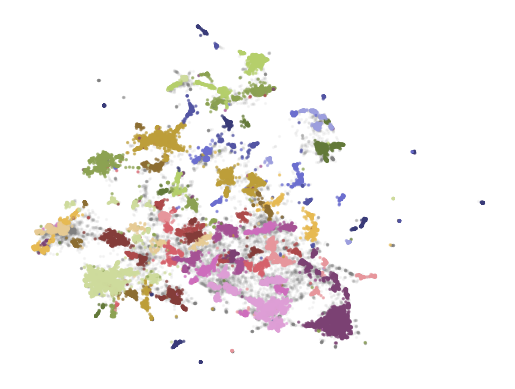

In [39]:
import matplotlib.pyplot as plt
# Plot outliers and non-outliers separately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

In [49]:
list(clusters_df[clusters_df["cluster"] == "1"]["title"])

['CoZo+ - A Content Zoning Engine for textual documents',
 'From Contracts in Structured English to CL Specifications',
 'Bridging the gap between Legal Practitioners and Knowledge Engineers\n  using semi-formal KR',
 'A CNL for Contract-Oriented Diagrams',
 'The Utility of Text: The Case of Amicus Briefs and the Supreme Court',
 'Application of Topic Models to Judgments from Public Procurement Domain',
 'The Role of Pragmatics in Legal Norm Representation',
 'Towards Meaningful Maps of Polish Case Law',
 'Constitutional Precedent of Amicus Briefs',
 'Extracting Formal Models from Normative Texts',
 'Legal Question Answering using Ranking SVM and Deep Convolutional Neural\n  Network',
 'Automatic Argumentative-Zoning Using Word2vec',
 'Extracting Formal Models from Normative Texts',
 'Detecting Large Concept Extensions for Conceptual Analysis',
 'A Web-Based Tool for Analysing Normative Documents in English',
 'Learning to Predict Charges for Criminal Cases with Legal Basis',
 'Predict